Filtering out weird pixels

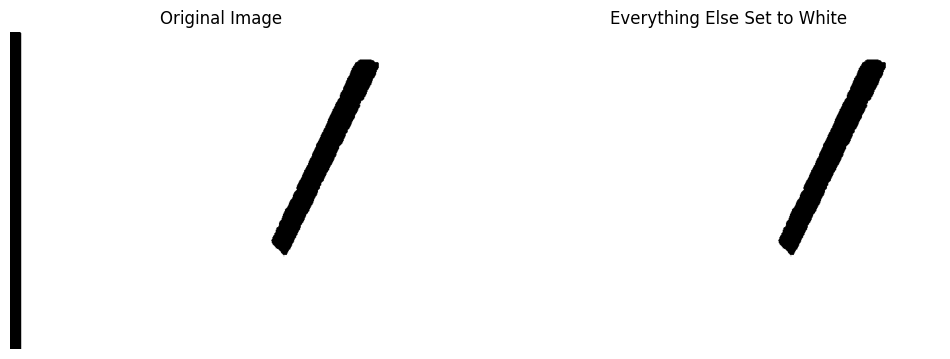

In [ ]:
# @title Default title text
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt

img = cv2.imread("output1.png")  # BGR format

# Thresholds
black_thresh = 50   # pixel is "black" if all channels <= 50
white_thresh = 205  # pixel is "white" if all channels >= 205

# Create masks
black_mask = np.all(img <= black_thresh, axis=-1)
white_mask = np.all(img >= white_thresh, axis=-1)

# Initialize output image to all white
output = np.full_like(img, 255)

# Set only black pixels (keep them)
output[black_mask] = [0, 0, 0]
# White pixels are already set to [255,255,255] by default
# Set left 50 columns to white
output[:, :50] = [255, 255, 255]


# Save and download
output_filename = 'filtered_bw_only.png'
cv2.imwrite(output_filename, output)

# Display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_rgb)
plt.title('Everything Else Set to White')
plt.axis('off')
plt.show()


Calculate Corner Coords

Topmost:     (529, 43)
Bottommost:  (414, 339)
Leftmost:    (395, 316)
Rightmost:   (557, 48)


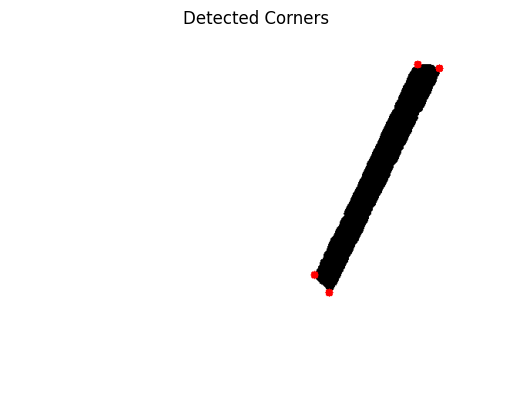

In [10]:
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt

img = cv2.imread("output1.png", cv2.IMREAD_GRAYSCALE)

height, width = img.shape

# Threshold to ensure binary image
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Initialize corner values
top_y = height
bottom_y = -1
left_x = width
right_x = -1

# Coordinates of the corners
topmost = (0, top_y)
bottommost = (0, bottom_y)
leftmost = (left_x, 0)
rightmost = (right_x, 0)

# Iterate through every pixel (streamed approach)
for y in range(height):
    for x in range(width):
        pixel = binary[y, x]
        if pixel == 0:  # black pixel
            # Topmost
            if y < top_y:
                top_y = y
                topmost = (x, y)

            # Bottommost
            if y > bottom_y:
                bottom_y = y
                bottommost = (x, y)

            # Leftmost
            if x < left_x:
                left_x = x
                leftmost = (x, y)

            # Rightmost
            if x > right_x:
                right_x = x
                rightmost = (x, y)

# Print results
print("Topmost:    ", topmost)
print("Bottommost: ", bottommost)
print("Leftmost:   ", leftmost)
print("Rightmost:  ", rightmost)

# Optional: draw the corners on the image for visual confirmation
img_color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
for pt in [topmost, bottommost, leftmost, rightmost]:
    cv2.circle(img_color, pt, 5, (0, 0, 255), -1)

# Show image
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Detected Corners")
plt.axis('off')
plt.show()


Generate slope LUT

In [12]:
import numpy as np

# Parameters
LUT_BITS = 6
LUT_SIZE = 1 << LUT_BITS  # 64
SCALE = 16  # Q4.4 fixed-point: 1.0 -> 16

# Initialize 2D LUT for fixed-point slope
slope_lut = np.zeros((LUT_SIZE, LUT_SIZE), dtype=np.uint8)

for dy_idx in range(LUT_SIZE):
    for dx_idx in range(1, LUT_SIZE):  # avoid divide-by-zero
        dy = dy_idx << 3
        dx = dx_idx << 3
        slope = dy / dx
        slope_fixed = min(int(slope * SCALE), 255)  # clamp to 8-bit
        slope_lut[dy_idx][dx_idx] = slope_fixed

# Set slope for dx = 0 case as max
slope_lut[:, 0] = 255

# Example usage
def get_slope(dx, dy):
    dx_idx = min(dx >> 3, LUT_SIZE - 1)
    dy_idx = min(dy >> 3, LUT_SIZE - 1)
    return slope_lut[dy_idx][dx_idx]

# === 3. Example corners from bounding box ===
topmost    = (529,  43)
bottommost = (414, 339)
leftmost   = (395, 316)
rightmost  = (557,  48)

# === 4. Pick best point pair ===
# Goal: large dx, not vertical
if topmost[0] > bottommost[0]:
    p1 = topmost
    p2 = leftmost
elif topmost[0] < bottommost[0]:
    p1 = leftmost
    p2 = bottommost
else:
    p1 = topmost
    p2 = bottommost

dx = abs(p2[0] - p1[0])
dy = abs(p2[1] - p1[1])

slope_q44 = get_slope(dx, dy)
slope_float = slope_q44 / SCALE

print(f"Using points: {p1} → {p2}")
print(f"dx = {dx}, dy = {dy}")
print(f"Slope (Q4.4 fixed): {slope_q44}")
print(f"Approx. slope: {slope_float:.3f}")


Using points: (529, 43) → (395, 316)
dx = 134, dy = 273
Slope (Q4.4 fixed): 34
Approx. slope: 2.125


(529, 43) (395, 316)


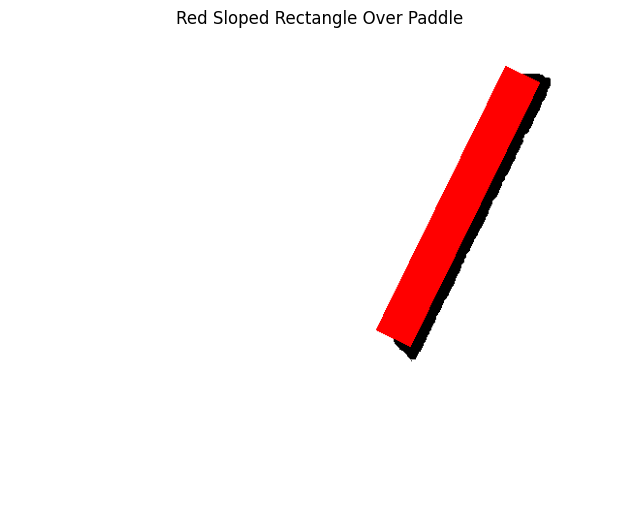

In [ ]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

# Load image (white background, black paddle)
img_path = "output1.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
height, width = img.shape

# Threshold to binary
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Iterate through every pixel (streamed approach)
for y in range(height):
    for x in range(width):
        pixel = binary[y, x]
        if pixel == 0:  # black pixel
            # Topmost
            if y < top_y:
                top_y = y
                topmost = (x, y)

            # Bottommost
            if y > bottom_y:
                bottom_y = y
                bottommost = (x, y)

            # Leftmost
            if x < left_x:
                left_x = x
                leftmost = (x, y)

            # Rightmost
            if x > right_x:
                right_x = x
                rightmost = (x, y)

# Corrected logic for choosing A and B
if topmost[0] > bottommost[0]:  # compare x-coordinates
    A = topmost
    B = leftmost
elif topmost[0] < bottommost[0]:
    A = leftmost
    B = bottommost
else:
    A = topmost
    B = bottommost


print(A,B)

# Direction vector and precomputed values
dx = B[0] - A[0]
dy = B[1] - A[1]
v2 = dx * dx + dy * dy
T = 40  # Thickness in pixels
max_dist2 = 400 * v2

# Create red rectangle overlay
img_color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

for y in range(height):
    for x in range(width):
        px = x - A[0]
        py = y - A[1]
        dot_pv = px * dx + py * dy
        dot_pn = px * -dy + py * dx
        if 0 <= dot_pv <= v2 and dot_pn * dot_pn <= max_dist2:
            img_color[y, x] = [0, 0, 255]  # Red

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Red Sloped Rectangle Over Paddle")
plt.axis('off')
plt.show()


A = (330, 83)
B = (403, 353)


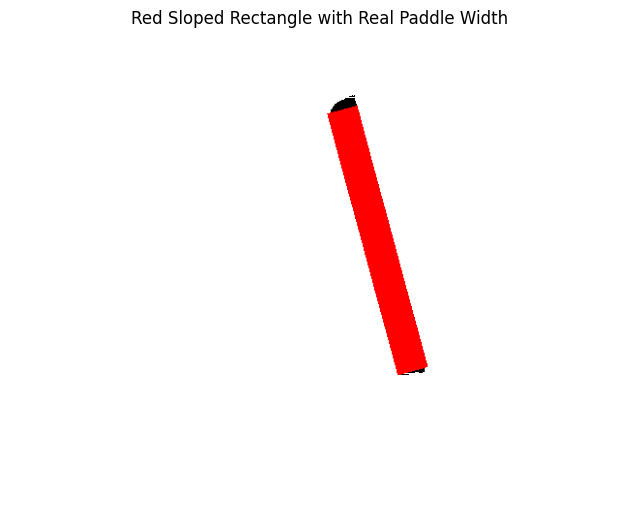

In [ ]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

# Load grayscale image
img_path = "output2.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
height, width = img.shape

# Threshold to binary
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Initialize corners
top_y = height
bottom_y = -1
left_x = width
right_x = -1
topmost = bottommost = leftmost = rightmost = (0, 0)

# Streaming corner detection
for y in range(height):
    for x in range(width):
        pixel = binary[y, x]
        if pixel == 0:
            if y < top_y:
                top_y = y
                topmost = (x, y)
            if y > bottom_y:
                bottom_y = y
                bottommost = (x, y)
            if x < left_x:
                left_x = x
                leftmost = (x, y)
            if x > right_x:
                right_x = x
                rightmost = (x, y)

# Choose line direction
if topmost[0] > bottommost[0]:
    A = topmost
    B = leftmost
elif topmost[0] < bottommost[0]:
    A = leftmost
    B = bottommost
else:
    A = topmost
    B = bottommost

print("A =", A)
print("B =", B)

# Vector AB
dx = B[0] - A[0]
dy = B[1] - A[1]
v2 = dx * dx + dy * dy

# Find min and max dot_pn values across black pixels
min_dot_pn = 2**31 - 1  # Max signed 32-bit int
max_dot_pn = -2**31     # Min signed 32-bit int

for y in range(height):
    for x in range(width):
        if binary[y, x] == 0:
            px = x - A[0]
            py = y - A[1]
            dot_pn = px * -dy + py * dx
            if dot_pn < min_dot_pn:
                min_dot_pn = dot_pn
            if dot_pn > max_dot_pn:
                max_dot_pn = dot_pn

# Draw the rectangle by checking if each pixel is between min/max projections
img_color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

for y in range(height):
    for x in range(width):
        px = x - A[0]
        py = y - A[1]
        dot_pv = px * dx + py * dy
        dot_pn = px * -dy + py * dx
        if 0 <= dot_pv <= v2 and min_dot_pn <= dot_pn <= max_dot_pn:
            img_color[y, x] = [0, 0, 255]

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Red Sloped Rectangle with Real Paddle Width")
plt.axis('off')
plt.show()


In [19]:
# Initialize the LUT

# Parameters
LUT_BITS = 6
LUT_SIZE = 1 << LUT_BITS  # 64
SCALE = 16  # Q4.4 fixed-point: 1.0 -> 16

# Initialize 2D LUT for fixed-point slope
slope_lut = np.zeros((LUT_SIZE, LUT_SIZE), dtype=np.uint8)

for dy_idx in range(LUT_SIZE):
    for dx_idx in range(1, LUT_SIZE):  # avoid divide-by-zero
        dy = dy_idx << 3
        dx = dx_idx << 3
        slope = dy / dx
        slope_fixed = min(int(slope * SCALE), 255)  # clamp to 8-bit
        slope_lut[dy_idx][dx_idx] = slope_fixed

# Set slope for dx = 0 case as max
slope_lut[:, 0] = 255

def get_slope(dx, dy):
    dx_idx = min(dx >> 3, LUT_SIZE - 1)
    dy_idx = min(dy >> 3, LUT_SIZE - 1)
    return slope_lut[dy_idx][dx_idx]

In [18]:
# Load image (white background, black paddle)
img_path = "output1.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
height, width = img.shape

# Threshold to binary
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
top_y = height
bottom_y = -1
left_x = width
right_x = -1
topmost = bottommost = leftmost = rightmost = (0, 0)

# Iterate through every pixel (streamed approach)
for y in range(height):
    for x in range(width):
        pixel = binary[y, x]
        if pixel == 0:  # black pixel
            # Topmost
            if y < top_y:
                top_y = y
                topmost = (x, y)

            # Bottommost
            if y > bottom_y:
                bottom_y = y
                bottommost = (x, y)

            # Leftmost
            if x < left_x:
                left_x = x
                leftmost = (x, y)

            # Rightmost
            if x > right_x:
                right_x = x
                rightmost = (x, y)

# Corrected logic for choosing A and B
if topmost[0] > bottommost[0]:  # compare x-coordinates
    A = topmost
    B = leftmost
elif topmost[0] < bottommost[0]:
    A = leftmost
    B = bottommost
else:
    A = topmost
    B = bottommost

print(A, B)

dx = A[0] - B[0]
dy = B[1] - A[1]

slope = get_slope(dx, dy)
print(slope)




(529, 43) (395, 316)
34
